# EMBEDDING + PADDING +biLSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout 
from keras.optimizers import * 
from keras.utils import np_utils 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import re
import spacy
import numpy as np
import pandas as pd
import en_core_web_sm
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
nlp = en_core_web_sm.load()

In [3]:
# Lets extract our sentences and have a look at the data we will be dealing with

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/appledata_sentiment.csv')
print('The shape of the dataframe is ', df.shape)
df.head()

The shape of the dataframe is  (4058, 5)


,Unnamed: 0,review,Country,vadar compound,sentiment
0,0,i got my new macbook pro m two weeks ago and ...,UK,0.9960,positive
1,1,i bought my mac from apple directly not from a...,UK,0.9440,positive
2,2,i own over computers and it blows away my ...,UK,0.8779,positive
3,3,it s a mac once you go mac you never go back ...,UK,0.0000,negative
4,4,dead at arrival kernel error took it to t...,UK,-0.7964,negative


In [4]:
import re
# Remove punctuation
df['review'] = df['review'].apply(str).map(lambda x: re.sub('[^a-zA-Z]',
' ', x))
# df['review'] = df['review'].apply(str).map(lambda x: re.sub('[^a-zA-Z]',
# ' ', x)) #Adding another layer of characters to be removed
# Convert the titles to lowercase
df['review'] = df['review'].apply(str).map(lambda x: x.lower())
# Print out the first rows of reviews
print(df['review'].apply(str).head())

0    i got my new macbook pro m  two weeks ago and ...
1    i bought my mac from apple directly not from a...
2    i own over    computers and it blows away my  ...
3    it s a mac once you go mac you never go back  ...
4    dead at arrival     kernel error  took it to t...
Name: review, dtype: object


In [5]:
data = df[['review', 'sentiment']]
data.head()

,review,sentiment
0,i got my new macbook pro m two weeks ago and ...,positive
1,i bought my mac from apple directly not from a...,positive
2,i own over computers and it blows away my ...,positive
3,it s a mac once you go mac you never go back ...,negative
4,dead at arrival kernel error took it to t...,negative


In [6]:
y = data['sentiment']
y

0       positive
1       positive
2       positive
3       negative
4       negative
          ...   
4053    negative
4054    positive
4055    negative
4056    negative
4057    positive
Name: sentiment, Length: 4058, dtype: object

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 1, 1, ..., 0, 0, 1])

In [8]:
X = data['review']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [10]:
tokenizer = Tokenizer(
    lower=True
)
padding = 'post'
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
sequences = []
max_sequence_len = 0
for text in X_train:
    # convert texts to sequence
    txt_to_seq = tokenizer.texts_to_sequences([text])[0]
    sequences.append(txt_to_seq)
    # find max_sequence_len for padding
    txt_to_seq_len = len(txt_to_seq)
    if txt_to_seq_len > max_sequence_len:
        max_sequence_len = txt_to_seq_len
# post padding
padded_sequences = pad_sequences(
    sequences, 
    maxlen=max_sequence_len, 
    padding=padding
)

In [11]:
%time
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_sequence_len-0))
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
adam = Adam(learning_rate=0.01)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=adam, 
    metrics=['accuracy']
)
model.summary()

history = model.fit(
    padded_sequences, 
    y_train, 
    epochs=10,
    verbose=1,
    batch_size=128
)
#score = model.evaluate(X_test, y_test, verbose=10) 
# print('Test loss:', score[0]) 
# print('Test accuracy:', score[1])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1257, 64)          379840    
                                                                 
 bidirectional (Bidirectiona  (None, 1257, 128)        66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1257, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 127s 5s/step - loss: 0.5762 - accuracy: 0.7311
Epoch 2/10
22/22 [==============================] - 116s 5s/step - loss: 0.3054 - accuracy: 0.8823
Epoch 3/10
22/22 [==============================] - 116s 5s/step - loss: 0.1363 - accuracy: 0.9566
Epoch 4/10
22/22 [==============================] - 117s 5s/step - loss: 0.0647 - accuracy: 0.9801
Epoch 5/10
22/22 [==============================] - 116s 5s/step - loss: 0.0377 - accuracy: 0.9886
Epoch 6/10
22/22 [==============================] - 116s 5s/step - loss: 0.0190 - accuracy: 0.9956
Epoch 7/10
22/22 [==============================] - 116s 5s/step - loss: 0.0110 - accuracy: 0.9978
Epoch 8/10
22/22 [==============================] - 116s 5s/step - loss: 0.0074 - accuracy: 0.9974
Epoch 9/10
22/22 [==============================] - 117s 5s/step - loss: 0.0085 - accuracy: 0.9982
Epoch 10/10
22/22 [==============================] - 116s 5s/step - loss: 0.0070 - accuracy: 0.9982


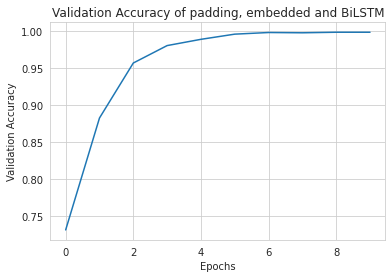

In [15]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['accuracy'])
title = plt.title("Validation Accuracy of padding, embedded and BiLSTM")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Validation Accuracy")